In [1]:
!pip3 install gym-minigrid

     |████████████████████████████████| 51kB 2.4MB/s 


In [2]:
from collections import deque
import gym, random, math
from tqdm import trange
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym_minigrid.wrappers import *
import torch.autograd as autograd 

#gym.logger.set_level(40)

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

def preprocess(image, cuda=False):
        image = np.array(image)
        image = image / 255.0
        image = torch.from_numpy(image)
        image = image.permute(2, 0, 1).numpy() 
        #image = image.unsqueeze(0).float() # Add 1 at the beginning
        if cuda: image = image.cuda()
        return image

In [4]:
env = gym.make('MiniGrid-Empty-5x5-v0')
env = RGBImgObsWrapper(env) # Get pixel observations
state = env.reset()
state = preprocess(state["image"])
#print(DQN(env.observation_space.shape, env.action_space.n))

In [5]:
class DQN(nn.Module):
    output_dim = 7
    #hidden2 = 32
    input_shape = state.shape
    print(input_shape)

    def __init__(self):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(0)
        #self.input_shape = input_shape
        #self.num_actions = num_actions


        self.features = nn.Sequential(
                nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1),
                nn.ReLU()
            )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.Tanh(),
            nn.Linear(512, self.output_dim),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

(3, 40, 40)


In [6]:
class Agent:
    output_dim = 7
    lr = 1e-3
    batch_size = 32
    gamma = 0.99

    def __init__(self):
        self.online_net = DQN()
        self.online_net.train()

        self.target_net = DQN()
        self.update_target_net()
        for param in self.target_net.parameters(): param.requires_grad = False

        self.optimiser = optim.Adam(self.online_net.parameters(), lr=self.lr)

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return self.online_net(state).argmax(1).item()

    def act_e_greedy(self, state, epsilon=0.01):
        if random.random() < epsilon:
            return random.randrange(self.output_dim)
        else:
            return self.act(state)

    def _sample_batch(self, buffer):
        s, a, r, ns, t = zip(*random.sample(buffer, self.batch_size)) #-> OJO
        #print(s.shape)
        #print(len(s),len(a))
        f, l = torch.FloatTensor, torch.LongTensor
        return f(s), l(a), f(r), f(ns), f(t)

    def train_iter(self, buffer):
        state, action, reward, next_state, terminal = self._sample_batch(buffer)

        q_value = self.online_net(state)[range(self.batch_size), action]
        with torch.no_grad():
            next_state_action = self.online_net(next_state).max(1)[1] # [1]online_net to get action for next_state
            next_qv = self.target_net(next_state)[range(self.batch_size), next_state_action] # target_net to get Q
            target_qv = reward + self.gamma * (1 - terminal) * next_qv
    
        loss = (q_value - target_qv).pow(2).mean()

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        return loss.item()

    def update_target_net(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

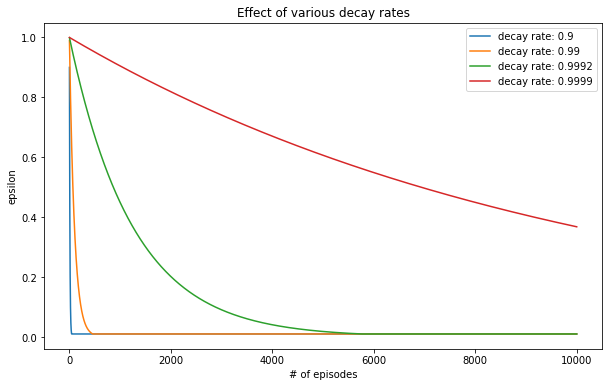

In [7]:
MAX_EPISODES = 10000
EPS_START = 1.0      # Default/starting value of eps
EPS_MIN = 0.01 

#0.998
EPS_DECAY_RATES = [0.9, 0.99, 0.9992, 0.9999]
plt.figure(figsize=(10,6))

for decay_rate in EPS_DECAY_RATES:
    test_eps = EPS_START
    eps_list = []
    for _ in range(MAX_EPISODES):
        test_eps = max(test_eps * decay_rate, EPS_MIN)
        eps_list.append(test_eps)          
    
    plt.plot(eps_list, label='decay rate: {}'.format(decay_rate))

plt.title('Effect of various decay rates')
plt.legend(loc='best')
plt.xlabel('# of episodes')
plt.ylabel('epsilon')
plt.show()

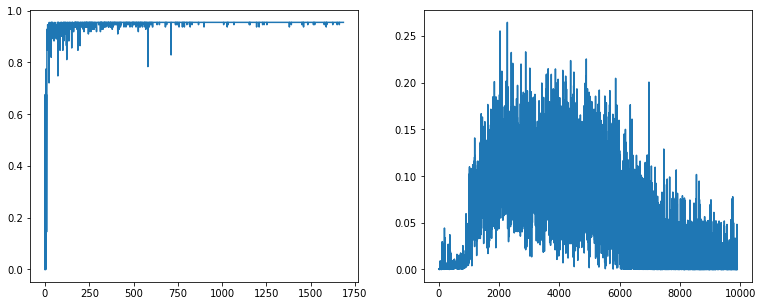

In [8]:
EPS_START = 1.0      # Default/starting value of eps
EPS_DECAY = 0.9992  # Epsilon decay rate 0.999
EPS_MIN = 0.01 
eps = EPS_START

buffer = deque(maxlen=5000)#
rewards, loss = [], []
episode_reward = 0
agent = Agent()


for i in range(10000):
    #eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500 #700
    action = agent.act_e_greedy(state, eps)
    next_state, reward, done, _ = env.step(action)
    next_state = preprocess(next_state["image"])

    buffer.append((state, action, reward, next_state, done))
    eps = max(eps * EPS_DECAY, EPS_MIN)
  
    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        state = preprocess(state["image"])
        rewards.append(episode_reward)
        episode_reward = 0
    
    if i > 100:
        loss.append(agent.train_iter(buffer))
   
    if i > 100 and i % 100 == 0:
        agent.update_target_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)

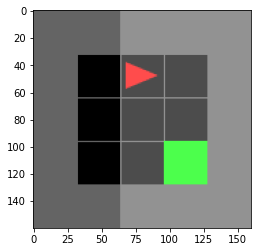

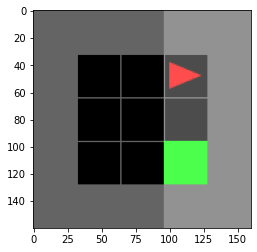

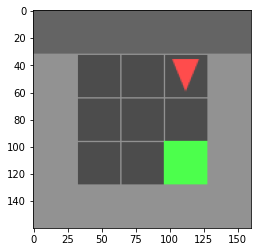

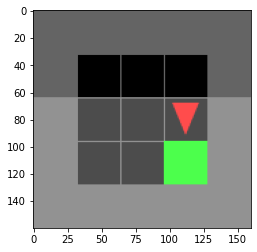

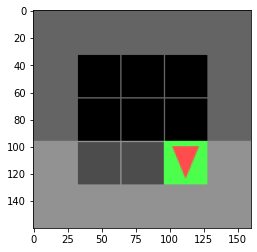

episode: 0 scored 0.955


In [9]:
for i in range(1):
    score = 0
    state = env.reset()
    state = preprocess(state["image"])
    
    scores = []
    a = 0
    while True:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = preprocess(next_state["image"])
        img = env.render('rgb_array')
        plt.imshow(np.concatenate([img], 1))
        plt.show()

        state = next_state        
        score += reward
        #print(score)
        scores = np.append(scores,score)
        a= a+1
        if done:
            break

    print('episode: {} scored {}'.format(i, score))